In [23]:
# Global imports 
import numpy as np
import librosa
from matplotlib import pyplot as plt

In [24]:
# Once these are set you should be able to run all
# Global folder variables 
# data paths
audio_folder = "data/BallroomData/"
annotations_folder = "data/BallroomAnnotations/"

# numpy binary dump paths
data_dump = 'data/ballroom_data_dump.npy'
evaluation_data_dump = 'data/analysis_dump.npy'

# test single song variables
genre = 'Jive'
file_name = 'Albums-Commitments-10'
single_audio_file = audio_folder + genre + "/" + file_name + '.wav'
single_audio_file_annotations = annotations_folder + file_name + ".beats"

# evaluation of data set variables
evaluate_dataset = False 
genres = ["ChaChaCha",
              "Jive", 
              "Quickstep", 
              "Rumba-American",  
              "Rumba-International", 
              "Rumba-Misc", 
              "Samba", 
              "Tango",
              "VienneseWaltz",
              "Waltz"]

# Onset Strength Envelope

Calculating a perceptually weighted onset strength envelope from ellis 2007 method.
- Audio resampled to 8 kHz
- Calculate STFT 32ms window, 4ms hop size 
- Mapped to 40 band Mel spectrogram
- Mel converted to dB
- First order difference along time calculated for each band
- Half wave rectification (Negative values set to zero)
- Sum across bands
- High pass filter 0.4 Hz (make it locally zero mean)
- Convolved with Gaussian envelope 20ms wide - *I havent done this step*
- Normalise onset envelope by dividing by musical excerpt standard deviation

This should result in 1D onset envelope strength as a function of time that responds to a proportional increase in energy summed across approximately auditory frequency bands.

In [25]:
from scipy.signal import butter, filtfilt, lfilter

# butterworth highpass filter
def high_pass_filter(y, sr, cutoff=0.4, order=1):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y, axis=0)
    return y_filtered

def mel_db(sr, stft, n_fft, hop_length, n_mels=40):
    abs_stft = abs(stft)
    
    # Create a Mel spectrogram with 40 Mel bands
    mel = librosa.feature.melspectrogram(S=abs_stft**2, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert power spectrogram (amplitude squared) to dB
    mel_db = librosa.power_to_db(mel)
    
    return mel_db
    
# Onset strength envelope
def onset_strength_envelope(y, sr, window_sec=0.032, hop_sec=0.004, show=False):    
    # Calculate the STFT with a 32ms window and 4ms hop size
    n_fft = int(window_sec * sr)  # Window seconds to samples
    hop_length = int(hop_sec * sr)  # Hop seconds to samples
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # apply mel scale with 40 bands
    mel = mel_db(sr, stft, n_fft, hop_length)
    
    # apply first order difference
    mel_dif = np.diff(mel, axis=1)
    
    # half wave rectify
    mel_half_rec = np.maximum(0, mel_dif)
    
    # sum across bands
    onset_strength = np.sum(mel_half_rec , axis=0)
    
    # librosa remove DC like this - How do they do this in lab solution?
    onset_strength = lfilter([1.0, -1.0], [1.0, -0.99], onset_strength, axis=-1)
    
    # normalise to standard deviation (add small number to avoid div by 0) 
    # find significant difference from mean   
    onset_strength_norm  = onset_strength / np.std(onset_strength) + 1e-10 
    
    if(show): plot_onset_envelope_strength(y, sr, onset_strength_norm, hop_sec)
        
    return onset_strength_norm

def plot_onset_envelope_strength(y, sr, onset_strength, hop_sec):
    hop_length = int(hop_sec * sr)
    
    # normalise range 0 - 1
    onset_strength = onset_strength / np.max(onset_strength)
    
    # Time vector for plotting
    times = librosa.frames_to_time(np.arange(len(onset_strength)), sr=sr, hop_length=hop_length)
    
    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # Plot waveform
    plt.plot(times, onset_strength)
    plt.title('Onset Strength Envelope')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Normalized Onset Strength')
    plt.xlim([0, 10])
    plt.ylim([-0.1, 1.1])
    plt.show()

# Global Tempo Estimate

Dynamic programming method dependant on tempo estimate.
- Use autocorrelation on onset strength envelope
- Apply perceptual weighting Gaussian window to raw autocorrelation
    - Gives TPS
    - Using T0 = 0.5 secs omegaT = 1.4 octaves
- Pick largest peak from TPS for tempo estimate

Extension:
Resample TPS to a half and a third, then adding the result to the original signal and picking the largest peak for tempo estimate.
- uses different values for T0 and omegaT

In [26]:

def plot_auto_c(auto_c, tps, faster_tempo, slower_tempo, selected_tempo, sr, hop_length):
    # calculate bpm for plot
    faster_tempo_bpm = round(60 * sr / (faster_tempo * hop_length), 2)
    slower_tempo_bpm = round(60 * sr / (slower_tempo * hop_length), 2)
    selected_tempo_bpm = round(60 * sr / (selected_tempo * hop_length), 2)
    
    auto_c = auto_c / np.max(auto_c)
    tps = tps / np.max(tps)
    
    times = np.arange(len(auto_c)) * (hop_length / sr)

    plt.plot(times, auto_c)
    plt.title('Auto-Correlation')
    plt.xlabel('Lag (seconds)')
    plt.show()

    plt.plot(times, tps)
    plt.vlines(faster_tempo * (hop_length / sr), ymin=min(tps), ymax=max(tps), color='g', linestyle='--', label='faster tempo: {} BPM'.format(faster_tempo_bpm))
    plt.vlines(slower_tempo * (hop_length / sr), ymin=min(tps), ymax=max(tps), color='r', linestyle='--', label='slower tempo: {} BPM'.format(slower_tempo_bpm))
    plt.legend()
    plt.title('Perception Weighted Auto-Correlation Tempo BPM: {}'.format(selected_tempo_bpm))
    plt.xlabel('Lag (seconds)')
    plt.show()
    
# Apply perceptual weighting based on tempo tapping data
def perceptual_weighting(t, t0=0.5, sigma_t=0.9): # t0 (bpm) and sigma_t (octaves) values from ellis 2007  
    # avoid div by zero error 
    epsilon = 1e-10
    t = np.maximum(t, epsilon)
    
    log_2_t_over_t0 = np.log2(t / t0)
    
    W_t = np.exp(-0.5 * (log_2_t_over_t0 / sigma_t) ** 2)
    
    return W_t

def tempo_multiples(tps):
    # only search 1/3 of the tps this should be plenty with 5 second tps
    tps_range = round(len(tps) / 3)
    
    tps_2 = np.zeros(tps_range)
    tps_3 = np.zeros(tps_range)

    for t in range(tps_range):
        # equation (7) and (8) - ellis 2007
        tps_2[t] = tps[t] + (0.5 * tps[2 * t]) + (0.25 * tps[(2 * t) - 1]) + (0.25 * tps[(2 * t) + 1])
        tps_3[t] = tps[t] + (0.33 * tps[3 * t]) + (0.33 * tps[(3 * t) - 1]) +(0.33 * tps[(3 * t) + 1])            
        
    duple = np.max(tps_2)
    triple = np.max(tps_3)
     
    # Whichever sequence contains the larger value determines whether the tempo is considered 
    # duple or triple, respectively, and the location of the largest value is treated as the 
    # faster target tempo, with one-half or one-third of that tempo, respectively, as the adjacent 
    # metrical level.   
    if duple > triple:
        faster_tempo_frame = np.argmax(tps_2)
        slower_tempo_frame = np.argmax(tps_2) * 2
        return faster_tempo_frame, slower_tempo_frame
    else: 
        faster_tempo_frame = np.argmax(tps_3)
        slower_tempo_frame = np.argmax(tps_3) * 3
        return faster_tempo_frame, slower_tempo_frame
  
def estimate_tempo(odf, sr, hop_sec=0.004, max_lag_s=5, weight_threshold_ratio=0.15, show=False):
    hop_length = int(hop_sec * sr)

    # only correlate reasonable tempo range 
    max_size = max_lag_s * sr / hop_length

    # auto correlate onset strength
    auto_c = librosa.autocorrelate(odf, max_size=max_size)

    # weighting function needs lag in seconds
    lags_seconds = np.arange(len(auto_c)) * (hop_length / sr)

    # apply perceptual weightinig get tempo period strengths
    tps = perceptual_weighting(lags_seconds) * auto_c
    
    # # calculate secondary bpm
    # # two further functions are calculated by resampling T P S to one-half and one-third, 
    # # respectively, of its original length, adding this to the original T P S, 
    # # then choosing the largest peak across both these sequences - ellis 2007
    faster_tempo_frame, slower_tempo_frame = tempo_multiples(tps)
    
    faster_tempo_peak = tps[faster_tempo_frame]
    slower_tempo_peak = tps[slower_tempo_frame]
    
    # Relative weights of the two levels are again taken from the relative peak heights 
    # at the two period estimates in the original T P S. This approach finds the tempo that maximizes
    # the sum of the T P S values at both metrical levels
    faster_tempo_weight = faster_tempo_peak / (faster_tempo_peak + slower_tempo_peak)
    slower_tempo_weight = slower_tempo_peak / (faster_tempo_peak + slower_tempo_peak)
               
    # start testing without - risk of over fitting to data set
    # weight difference decision rule - not explicitly mentioned in the paper - this is my idea 
    
    # weight difference threshold
    if (slower_tempo_weight > faster_tempo_weight): selected_tempo = slower_tempo_frame
    # test with decision rule - add in comparison to original tps peak 
    #else if abs(faster_tempo_weight - slower_tempo_weight) > weight_threshold_ratio: selected_tempo = slower_tempo_frame
    else: selected_tempo = faster_tempo_frame
        
    # plot results
    if(show): 
        print("faster_tempo_level: {}, slower_tempo_level {}".format(faster_tempo_peak, slower_tempo_peak))
        print("faster_tempo weigth: {}, slower_tempo weight {}".format(faster_tempo_weight, slower_tempo_weight))
        print('weight ratio: {}'.format(abs(faster_tempo_weight - slower_tempo_weight)))
        plot_auto_c(auto_c, tps, faster_tempo_frame, slower_tempo_frame, selected_tempo, sr, hop_length)

    return selected_tempo

# Beat Tracking
- Using dynamic programming to find each beat.
- Follow source code on Ellis 2007 paper.

In [27]:
def plot_dynamic_programming(c_score, backlink, ose, beats):
    # plot the cumulative score and onset strength envelope
    plt.figure(figsize=(14, 6))
    plt.plot(ose, label='Onset Strength Envelope', color='blue', alpha=0.5)
    plt.plot(c_score, label='Cumulative Score', color='orange', alpha=0.8)

    # add arrows for backlinks
    for i in range(1, len(c_score)):
        if backlink[i] != -1:
            plt.annotate('', xy=(i, c_score[i]), xytext=(backlink[i], c_score[backlink[i]]),
                        arrowprops=dict(arrowstyle="<-", color='gray', alpha=0.5))

    # highlight the beats
    plt.scatter(beats, c_score[beats], color='red', zorder=5, label='Beats')

    plt.title('Dynamic Programming Beat Tracking Visualization')
    plt.xlabel('Time (frames)')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# ported from ellis 2007 matlab code
def beat_track(ose, tempo_estimate, sr, alpha=680, hop_sec=0.004, show=False):
    # initialize backlink and cumulative score arrays
    backlink = -np.ones(len(ose), dtype=int)
    c_score = ose.copy()
    
    # define search range for previous beat based on the period
    prev_range = np.arange(-2*tempo_estimate, -round(tempo_estimate/2), dtype=int)
    
    # calculate transition cost using a log-gaussian window over the search range
    cost = -alpha * np.abs(np.log(prev_range / -tempo_estimate) ** 2)

    # set up the dynamic programming loop bounds
    loop_start = max(-prev_range[0], 0)
    loop_end = len(ose)
    
    # use the loop to fill in backlink and cumlative score
    for i in range(loop_start, loop_end):
        timerange = i + prev_range
        # ensure timerange indices are within bounds
        valid_timerange = timerange[(timerange >= 0) & (timerange < len(ose))]
        if len(valid_timerange) == 0:
            continue  # skip if no valid timerange
        
        # calculate score candidates and find the best predecessor beat
        score_candiadates = cost[:len(valid_timerange)] + c_score[valid_timerange]
        max_score_index = np.argmax(score_candiadates)
        max_score = score_candiadates[max_score_index]
        
        # update cumulative score and backlink
        c_score[i] = max_score + ose[i]
        backlink[i] = valid_timerange[max_score_index]
    
    # start backtrace from the highest cumulative score
    beats = [np.argmax(c_score)]
    
    # backtrace to find all predecessors
    while backlink[beats[0]] > 0:
        beats.insert(0, backlink[beats[0]])
    
    hop_length = int(hop_sec * sr)
    times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)
    
    if(show): plot_dynamic_programming(c_score, backlink, ose, beats) # this can take more than 1 minute to render
    
    return times

# Run full system

In [28]:
def plot_estimated_vs_annotation(y, sr, beats_estimates, annotations, name, genre, xlim=[10, 20],):
    plt.figure(figsize=(10, 4))
    plt.title('Beats {} {}'.format(name, genre)) # add bpm
    plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # plot waveform
    plt.vlines(beats_estimates, ymin=0, ymax=max(y), color='r', linestyle='--', label='Estimates')  # plot beats
    plt.vlines(annotations, ymin=min(y), ymax=0, color='g', linestyle='--', label='Annotations')  # plot annotations
    plt.legend()
    plt.xlim(xlim)
    

# The whole system should be called via this function
def beatTrack(audio_file, name="", genre="", annotations=[], show=False):
    hop_sec=0.004
    resample_rate = 8000

    # load audio
    y, sr = librosa.load(audio_file, sr=resample_rate)
    ose = onset_strength_envelope(y, sr, hop_sec=hop_sec, show=show)
    tempo_estimate = estimate_tempo(ose, sr, hop_sec=hop_sec, show=show)
    beats_estimates = beat_track(ose, tempo_estimate, sr, hop_sec=hop_sec, show=False) # plot here can take up to a miniute
    
    if(show and len(annotations) > 0): 
        # plot estimated vs reference 
        plot_estimated_vs_annotation(y, sr, beats_estimates, annotations, name, genre)
    
    return beats_estimates

# Evaluation

In [29]:
from mir_eval import beat as beats_eval

def evaluation(beats_annotation, beats_estimate, trim=False):
    if trim: 
        beats_annotation = beats_eval.trim_beats(beats_annotation)
        beats_estimate = beats_eval.trim_beats(beats_estimate)
    
    f_measure = beats_eval.f_measure(beats_annotation, beats_estimate)
    cemgil = beats_eval.cemgil(beats_annotation, beats_estimate)
    goto = beats_eval.goto(beats_annotation, beats_estimate)
    # p_score = beats_eval.p_score(beats_ref, beats_est) broken: numpy depricated int error in mir_eval lib
    continuity = beats_eval.continuity(beats_annotation, beats_estimate)
    information_gain = beats_eval.information_gain(beats_annotation, beats_estimate)
    
    return {
        "f_measure": f_measure, 
        "cemgil": cemgil,
        "goto": goto,
        #"p_score": p_score, broken - see above comment
        "continuity": continuity, 
        "information_gain": information_gain 
    }

# Testing on full dataset

In [30]:
import os

class Song:
    name = None
    audio_file = None
    annotations_file = None
    genre = None
    meter = None
    beats_annotation = None
    beats_estimates = None
    evaluation = None
    tempo = None

def get_beat_annotations(beats_path):
    beats_file = open(beats_path, 'r')
    beats_lines = beats_file.readlines()
    beats_annotation = np.array([])

    for line in beats_lines:
        beat = line[:10] # take 10 digits of the beat time
        beats_annotation = np.append(beats_annotation, float(beat))
       
    return beats_annotation 
 
def read_data(audio_dir, annotation_dir, recompute = 0): # adapted from lab 2 solution
    """Creates an array of objects, one for each file, containing path names
    for audio and annotation files, dance style, metre and tempo.
    Each audio file is in a folder defining the dance style
    (e.g. samba, cha cha, waltz). A parallel set of annotation files contain
    two integers for each piece giving the beginning and end of the first bar,
    in milliseconds.
    """
    dump_file = data_dump
    if not recompute and os.path.exists(dump_file):
        return np.load(dump_file, allow_pickle=True)
    
    songs: Song = []
    for entry in os.scandir(audio_dir):
        if os.path.isdir(entry) == False: continue # ignore hidden files
     
        for file in os.scandir(entry.path):
            song = Song()
            song.audio_file = file.path
            song.annotations_file = annotation_dir + '/' + file.name[:-4] + ".beats"
            song.name = file.name[:-4]
            song.genre = entry.name
            if song.genre[-5:] == 'Waltz':
                song.metre = 3
            else:
                song.metre = 4
            song.beats_annotation = get_beat_annotations(song.annotations_file)
            song.tempo = 60 / (song.beats_annotation[1] - song.beats_annotation[0]) # this is not very accurate
            songs.append(song)

    np.save(dump_file, songs)
    return songs
 
# evaluate the data set based on the f-measure
def test_dataset(songs_data, genres=[], trim=False, recompute=False, show=False):
    # dump output for quick evaluation
    dump_file = evaluation_data_dump
    if not recompute and os.path.exists(dump_file):
        return np.load(dump_file, allow_pickle=True)
    
    # use numpy structured array for binary dump
    dtype = [('genre', 'U20'), ('f_measure_mean', 'f8')]
    f_measure_means = np.array([], dtype=dtype)
    
    global_f_measure_sum = 0.0
    global_f_measure_count = 0
    
    for genre in genres: 
        # create mean variables
        genre_f_measure_sum = 0.0
        genre_songs_count = 0
        
        for song in songs_data:
            if song.genre != genre: continue # only test selected genres 
            beats = beatTrack(song.audio_file, name=song.name, genre=song.genre, annotations=song.beats_annotation, show=show)
            evaluation_results = evaluation(song.beats_annotation, beats, trim=trim)
            
            # f_measure for genre
            genre_songs_count += 1
            genre_f_measure_sum += evaluation_results['f_measure']
            
            # f_measure for all songs
            global_f_measure_count += 1
            global_f_measure_sum += evaluation_results['f_measure']
        
        # calculate mean for genre
        new_row = np.array([(genre, genre_f_measure_sum / genre_songs_count)], dtype=dtype)
        f_measure_means = np.concatenate((f_measure_means, new_row), axis=0)
        
    # calculate global mean
    global_mean = global_f_measure_sum / global_f_measure_count
    f_measure_means = np.concatenate((f_measure_means, np.array([('Global', global_mean)], dtype=dtype)), axis=0)
    
    np.save(dump_file, f_measure_means) 
    return f_measure_means 

def plot_results(f_measure_means):
    names = list(f_measure_means.keys())
    values = list(f_measure_means.values())
        
    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, values)

    plt.xlabel('Genres')
    plt.ylabel('F-Measure')
    plt.title('F-Measures')
    plt.xticks(rotation=45) 
    
    # add values to bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')
    
    plt.show()


# Single file 

### Beat beats array

In [31]:
# On a single file
audio_file = single_audio_file
beats = beatTrack(audio_file)
print(beats)

[ 0.4    0.768  1.136  1.5    1.88   2.256  2.616  2.992  3.352  3.728
  4.1    4.476  4.856  5.24   5.596  5.956  6.332  6.708  7.072  7.46
  7.84   8.216  8.588  8.956  9.324  9.704 10.08  10.448 10.816 11.192
 11.56  11.932 12.296 12.668 13.048 13.424 13.792 14.168 14.532 14.912
 15.28  15.656 16.024 16.396 16.756 17.136 17.504 17.876 18.248 18.612
 18.988 19.356 19.736 20.108 20.484 20.836 21.22  21.604 21.968 22.344
 22.716 23.096 23.46  23.836 24.208 24.568 24.94  25.316 25.688 26.06
 26.432 26.8   27.168 27.536 27.908 28.288 28.664 29.024 29.396 29.748]


### Plot Onset Strength Envelope, Auto-Correlation, Final beats vs Annotations

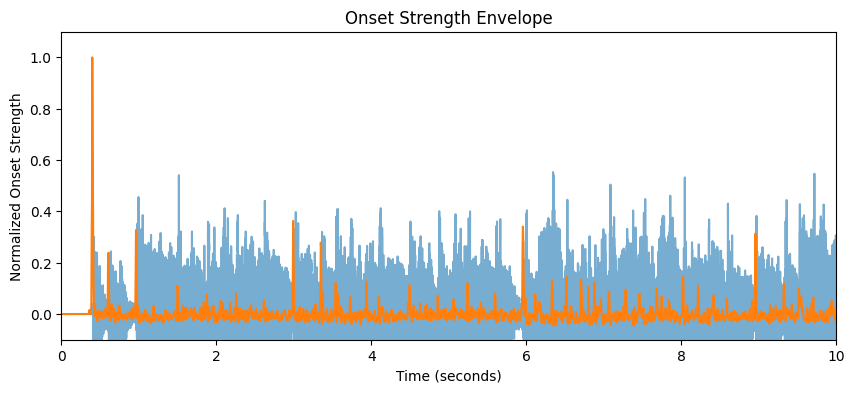

faster_tempo_level: 991.8184116062791, slower_tempo_level 830.3980076169213
faster_tempo weigth: 0.5442923250735965, slower_tempo weight 0.45570767492640357
weight ratio: 0.08858465014719291


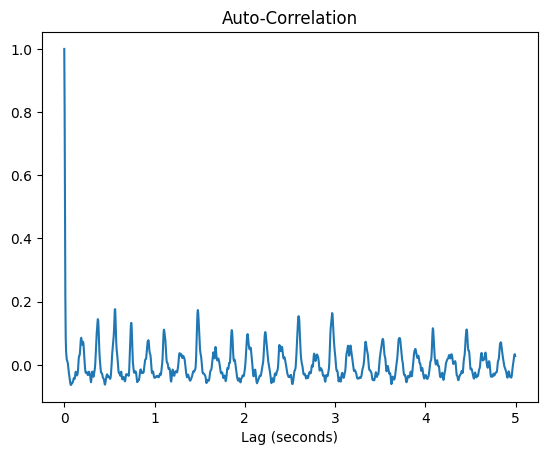

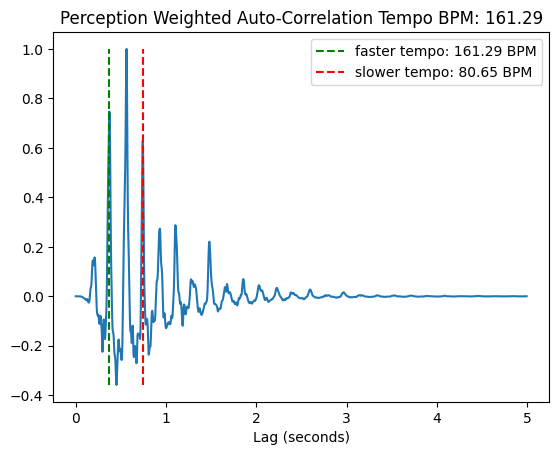

{'f_measure': 1.0, 'cemgil': (0.9481945709253308, 0.9481945709253308), 'goto': 1.0, 'continuity': (1.0, 1.0, 1.0, 1.0), 'information_gain': 0.7376007150396658}


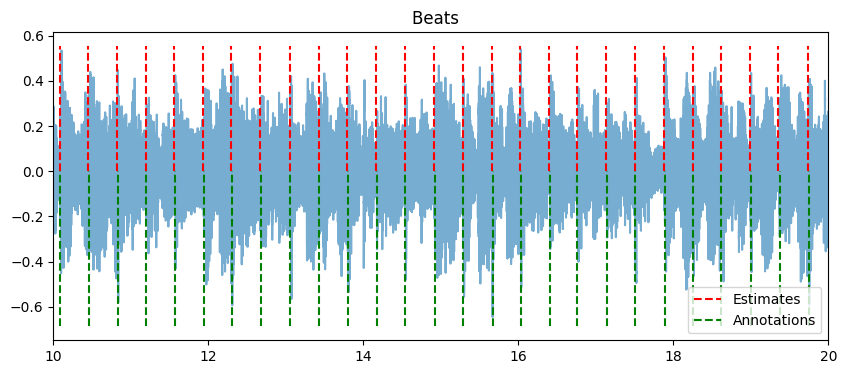

In [32]:
audio_file = single_audio_file
annotations_path = single_audio_file_annotations
annotations = get_beat_annotations(annotations_path)
beats = beatTrack(audio_file, annotations=annotations, show=True)
evaluation_results = evaluation(beats, annotations, trim=True)
print(evaluation_results)

# Evaluation of the performance on dataset

In [33]:
if evaluate_dataset:
    # evaluate system on dataset 
    audio_path = audio_folder
    annotations_path = annotations_folder
    recompute_data=True
    songs_data = read_data(audio_path, annotations_path, recompute=recompute_data)
    genres = genres 
    #sub_set_genres = ["Rumba-American"] # test a subset of the data

    trim=True # ignore first 5 seconds of beats
    recompute_analysis=True # override numpy binary file dump
    show=False # include plot 
    f_measure_means = test_dataset(songs_data, 
                                genres=genres, 
                                trim=trim, 
                                recompute=recompute_analysis, 
                                show=show) # runtime ~2-3 mins on all data

    # convert to dictonary for plotting
    f_measure_means = {item['genre']: item['f_measure_mean'] for item in f_measure_means}
    plot_results(f_measure_means)

# Extra
# evaluate different free variables 
# find best performer and worst performer ?